In [1]:
import os
import cv2
import torch
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm
import datetime
import shutil
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModel
import torchvision.transforms as transforms
import  torch.optim as optim
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from torch.utils.data import DataLoader, TensorDataset,Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
import imgaug.augmenters as iaa
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report


# Define Constant

In [2]:
FILE_PATH= "/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4" # Example to test functions
video_path = '/kaggle/input/shop-lifter/Shop DataSet'  # Path to your dataset
class_0 = "non shop lifters"
class_1 = "shop lifters"
out_path = "/kaggle/working/aug_vid"
if not os.path.exists(out_path):
    os.makedirs(out_path)
# Parameters
num_frames =16             # Number of frames to extract from each video
height, width = 224, 224        # Dimensions to resize each frame
channels = 3                  # Number of channels (RGB)
batch_size = 8          # Batch size for training
epochs = 30                   # Number of training epochs

# Split Data to Train,Test, and Val

In [3]:


def split_dataset(video_path, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    # Ensure sizes sum up to 1.0
    assert train_size + val_size + test_size == 1.0, "Train, val and test sizes must sum up to 1"
    
    # Create output directories for train, test, and val splits
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    for split_dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)

    # List the class folders
    class_folders = [f for f in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, f))]

    for class_folder in class_folders:
        class_folder_path = os.path.join(video_path, class_folder)
        videos = os.listdir(class_folder_path)

        random.shuffle(videos)  # Shuffle videos randomly

        # Calculate the number of items in each set
        total_videos = len(videos)
        train_count = int(total_videos * train_size)
        val_count = int(total_videos * val_size)

        # Split into train, validation, and test sets
        train_videos = videos[:train_count]
        val_videos = videos[train_count:train_count + val_count]
        test_videos = videos[train_count + val_count:]

        # Create class folders inside train, val, and test directories
        for folder_name, split_videos in zip(['train', 'val', 'test'], [train_videos, val_videos, test_videos]):
            split_class_dir = os.path.join(output_dir, folder_name, class_folder)
            if not os.path.exists(split_class_dir):
                os.makedirs(split_class_dir)

            # Copy videos to corresponding folders
            for video in split_videos:
                src_path = os.path.join(class_folder_path, video)
                dest_path = os.path.join(split_class_dir, video)
                shutil.copy2(src_path, dest_path)  # You can change to shutil.move to move instead of copy
                
    print("Dataset split into train, val, and test sets!")

# Example usage
video_path = '/kaggle/input/shop-lifter/Shop DataSet'  # Path to your dataset
output_dir = '/kaggle/working/split_data'  # Output folder for the splits

split_dataset(video_path, output_dir)


Dataset split into train, val, and test sets!


In [4]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

In [5]:
train_dir

'/kaggle/working/split_data/train'

In [6]:

def get_videos_files(path):
    all_videos = []
    for label, class_name in enumerate(os.listdir(path)):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for video_name in os.listdir(class_path):
                video_file = os.path.join(class_path, video_name)
                if video_file.endswith('.mp4'):  # Adjust for your video format
                    all_videos.append((video_file, label))
    return all_videos



In [7]:
train_files = get_videos_files(train_dir)
test_files = get_videos_files(test_dir)
val_files = get_videos_files(val_dir)

print(f"Total Train videos: {len(train_files)}")
print(f"Total test videos: {len(test_files)}")
print(f"Total Val videos: {len(val_files)}")

Total Train videos: 597
Total test videos: 131
Total Val videos: 127


In [8]:
train_files[0]

('/kaggle/working/split_data/train/shop lifters/videyyyyyyyyyss_22.mp4', 0)

# Video Augmentation

In [10]:


def augment_video(frames):
    """Apply a random combination of augmentations to video frames using albumentations."""
    
    # Define the individual augmentations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),  # Flip with a 50% chance
        A.Rotate(limit=10, p=0.5),  # Randomly rotate between -10 and 10 degrees
        A.RandomCrop(width=20, height=20, p=0.5),  # Random crop
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Random brightness/contrast adjustment
    ])

    # Apply augmentations to each frame
    frames_aug = [transform(image=frame)['image'] for frame in frames]

    return frames_aug


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
def count_frames(video_path):
    """Count the number of frames in a video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return 0
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

In [12]:
def average_frames(video_dir):
    """Calculate the average number of frames for all videos in the specified directory."""
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    total_frames = 0
    video_count = 0
    
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        frame_count = count_frames(video_path)
        if frame_count > 0:  # Ensure valid frame count
            total_frames += frame_count
            video_count += 1

    # Calculate average
    average = total_frames / video_count if video_count > 0 else 0
    return average


In [13]:
# Path to your dataset
avg_frames_0 = average_frames(os.path.join(video_path,class_0))
print(f"Average number of frames per video in class 0: {avg_frames_0:.2f}")

Average number of frames per video in class 0: 347.78


In [14]:
# Path to your dataset
avg_frames_1 = average_frames(os.path.join(video_path,class_1))
print(f"Average number of frames per video in class 1: {avg_frames_1:.2f}")

Average number of frames per video in class 1: 304.60


In [15]:
Total_frames_average  = (avg_frames_0  + avg_frames_1) //2
Total_frames_average

326.0

In [16]:
num_frames = int(Total_frames_average * .8 )
num_frames

260

In [57]:
def extract_frames(video_path, num_frames,height, width, channels):
    """Extract about 16 evenly spaced frames from the video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return []
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print(f"Video has fewer frames than requested ({total_frames} < {num_frames}).")
        return []
    
    # Calculate interval between frames to extract
    frame_interval = total_frames // num_frames

    frames = []
    for i in range(num_frames):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        ret, frame = cap.read()
        frame = cv2.resize(frame, (width, height))
#                 frame = frame.astype('float32') / 255.0
        if ret:
            frames.append(frame)  # Store the frame
        else:
            break  # Exit if there are any issues reading frames

    cap.release()
    return frames

In [18]:
class_names = []
video_counts = []
def check_balance(path):
    
    for label, class_name in enumerate(os.listdir(path)):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
            class_names.append(class_name)
            video_counts.append(len(os.listdir(class_path)))
    
    return class_names,video_counts


In [19]:
class_names = []
video_counts =[]
class_names,video_counts = check_balance(train_dir)


In [20]:
class_names, video_counts

(['shop lifters', 'non shop lifters'], [226, 371])

In [21]:
class_names = []
video_counts =[]
class_names,video_counts = check_balance(val_dir)

In [22]:
class_names, video_counts

(['shop lifters', 'non shop lifters'], [48, 79])

In [23]:
label = []
for i, loops in enumerate(video_counts):
    for j in range(loops):
        label.append(i)
print(len(label))    

127


In [24]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict) 

{0: 1.3229166666666667, 1: 0.8037974683544303}


In [25]:

def process_and_augment_videos(all_videos, out_path, num_frames=1, frame_step=2):
    for i in range(0, len(all_videos), frame_step):
        video, label = all_videos[i]
        
        if label == 1:
            frames = []
            cap = cv2.VideoCapture(video)
            
            if not cap.isOpened():
                print(f"Error opening video file {video}")
                continue

            frame_count = 0
            # Read frames from the video
            while cap.isOpened() and frame_count < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                # Resize frame to fixed dimensions if needed
                frame = cv2.resize(frame, (width, height))
                
                # Append frame to the list
                frames.append(frame)
                frame_count += 1

            cap.release()

            # Convert list of frames to NumPy array for augmentation
            video_np = np.array(frames)
            
            # Perform augmentation
            augmented_frames = augment_video(video_np)

            # Save augmented video
            video_filename = f'{str(datetime.datetime.now())}.mp4'
            video_output_path = os.path.join(out_path, video_filename)

            # Define video writer with the same width and height as frames
            out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

            # Write augmented frames to the output video file
            for frame in augmented_frames:
                out.write(frame)

            out.release()

            # Append new video path and label to `all_videos`
            all_videos.append((video_output_path, label))
        
    return all_videos
        

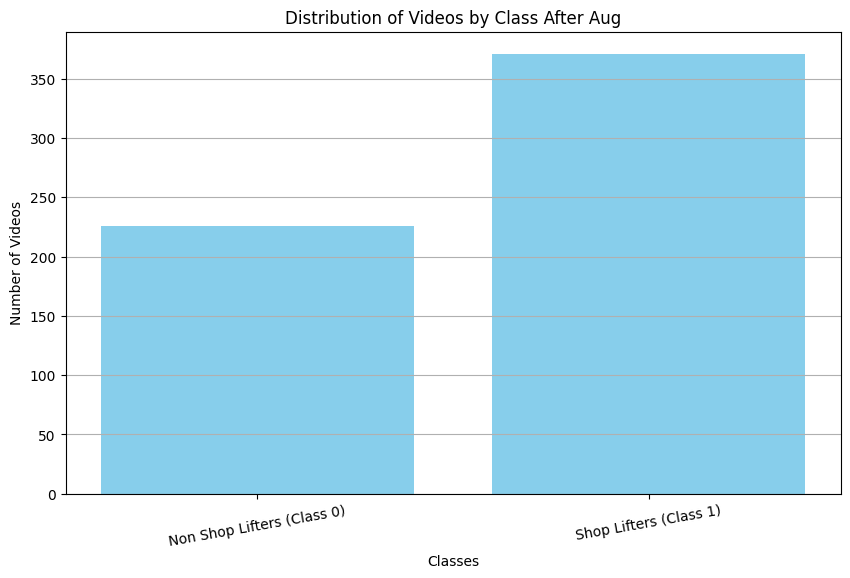

In [26]:
# Count the number of videos for each class
class_0_count = sum(1 for video in train_files if video[1] == 0)
class_1_count = sum(1 for video in train_files if video[1] == 1)

classes = ['Non Shop Lifters (Class 0)', 'Shop Lifters (Class 1)']
counts = [class_0_count, class_1_count]



plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Videos')
plt.title('Distribution of Videos by Class After Aug')
plt.xticks(rotation=10)
plt.grid(axis='y')
plt.show()

In [27]:
aug_train_files = process_and_augment_videos(train_files, out_path, num_frames=num_frames, frame_step=3)

In [28]:
print(f"Total Train videos: {len(aug_train_files)}")
print(f"Total test videos: {len(test_files)}")
print(f"Total Val videos: {len(val_files)}")

Total Train videos: 720
Total test videos: 131
Total Val videos: 127


In [29]:
# Count the total number of videos in the list
total_videos = len(train_files)
print("Total number of videos:", total_videos)

# Count the number of videos for each class
class_0_count = sum(1 for video in aug_train_files if video[1] == 0)
class_1_count = sum(1 for video in aug_train_files if video[1] == 1)

print("Number of class 0 videos:", class_0_count)
print("Number of class 1 videos:", class_1_count)

Total number of videos: 720
Number of class 0 videos: 226
Number of class 1 videos: 494


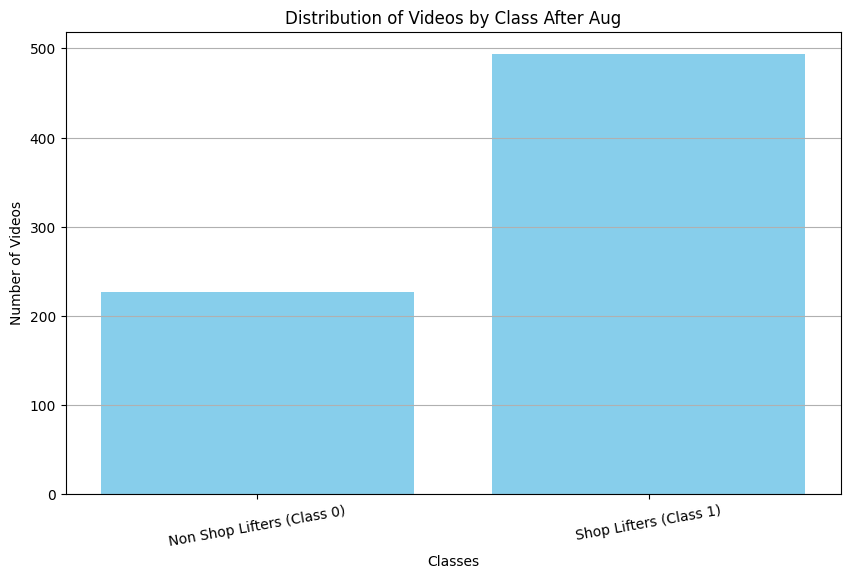

In [30]:

classes = ['Non Shop Lifters (Class 0)', 'Shop Lifters (Class 1)']
counts = [class_0_count, class_1_count]



plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Videos')
plt.title('Distribution of Videos by Class After Aug')
plt.xticks(rotation=10)
plt.grid(axis='y')
plt.show()

# Video generator

In [31]:
def video_generator(videos, batch_size, height, width, channels, class_weights, num_frames=16 ):
    """Generator function to yield video batches with class weights from pre-defined video list."""
    while True:  # Loop indefinitely
        random.shuffle(videos)  # Shuffle the videos for each epoch

        data = []
        labels = []
        weights = []

        # Iterate through the shuffled list of videos
        for video_file, label in videos:
            frames = []
            
            frames = extract_frames(video_file, num_frames,height, width, channels)


            # If the video has fewer frames than required, pad with zeros
            while len(frames) < num_frames:
                frames.append(np.zeros((height, width, channels), dtype=np.uint8))

            # Convert frames list to numpy array
            frames = np.array(frames)
          
            
            # Append the processed video, its label, and the corresponding weight
            data.append(frames)
            labels.append(label)

            # Yield batch of videos when data list reaches batch_size
            if len(data) == batch_size:
#                 yield np.array(data), np.array(labels), np.array(weights)
                yield np.array(data), np.array(labels)
                data = []  # Reset data list for the next batch
                labels = []  # Reset labels list for the next batch
#                 weights = []  # Reset weights list for the next batch

        # If there are leftover videos that don't fill a full batch, yield them
        if len(data) > 0:
#             yield np.array(data), np.array(labels), np.array(weights)
            yield np.array(data), np.array(labels)


In [32]:
train_files [0]

('/kaggle/working/split_data/train/shop lifters/videyyyyyyyyyss_22.mp4', 0)

In [134]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base")

processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics").to(device)


In [135]:
len(aug_train_files)

720

In [136]:
num_frames =16


test_gen = video_generator(test_files, batch_size , height, width, channels, class_weights,num_frames)
val_gen = video_generator(val_files, batch_size , height, width, channels, class_weights,num_frames)

In [137]:
aug_train_files[0]

('/kaggle/working/split_data/train/shop lifters/videppppsss_1.mp4', 0)

In [138]:
train_gen = video_generator(aug_train_files, batch_size , height, width, channels, class_weights,num_frames)
try:
    video, label = next(train_gen)
    print(video.shape)
except StopIteration:
    print("No more data to yield from the generator.")

(8, 16, 224, 224, 3)


In [139]:
# Create a DataFrame
df = pd.DataFrame(aug_train_files, columns=['file_path', 'label'])

# Display the DataFrame
print(df)

                                             file_path  label
0    /kaggle/working/split_data/train/shop lifters/...      0
1    /kaggle/working/split_data/train/non shop lift...      1
2    /kaggle/working/aug_vid/2024-10-05 10:32:25.75...      1
3    /kaggle/working/split_data/train/shop lifters/...      0
4    /kaggle/working/split_data/train/non shop lift...      1
..                                                 ...    ...
715  /kaggle/working/aug_vid/2024-10-05 10:32:28.05...      1
716  /kaggle/working/split_data/train/shop lifters/...      0
717  /kaggle/working/split_data/train/non shop lift...      1
718  /kaggle/working/split_data/train/non shop lift...      1
719  /kaggle/working/split_data/train/non shop lift...      1

[720 rows x 2 columns]


In [140]:


# Assuming df is your DataFrame with video paths and labels
video_paths = df['file_path'].tolist()  # List of video paths
labels = df['label'].tolist()  # List of labels

# Preprocess all videos
inputs_list = []
labels_list = []

# Use tqdm to wrap the zip iterator for progress tracking
for video_path, label in tqdm(zip(video_paths, labels), total=len(video_paths), desc="Processing videos"):
    # Preprocess video frames (this should return a tensor or a dict containing a tensor)
    inputs = preprocess_video_frames(video_path)  # This should return something like {'pixel_values': <tensor>}

    # Assuming 'inputs' is a dict and 'pixel_values' is the key holding the video frames tensor
    if 'pixel_values' in inputs:
        pixel_values = inputs['pixel_values']

        # Ensure that pixel_values is a tensor and has consistent dimensions
        if isinstance(pixel_values, torch.Tensor):
            inputs_list.append(pixel_values)
        else:
            print(f"Error: Expected tensor for pixel values, got {type(pixel_values)}")
            continue  # Skip if the input is invalid
    else:
        print(f"Error: 'pixel_values' not found in inputs for {video_path}")
        continue  # Skip if 'pixel_values' is not found

    # Append the corresponding label
    labels_list.append(label)

# Ensure that there are valid inputs before stacking
if inputs_list:
    # Stack all video tensors into a single tensor
    inputs_tensor = torch.cat(inputs_list, dim=0)  # Concatenate along the batch dimension
    # Convert the labels list to a tensor
    labels_tensor = torch.tensor(labels_list)

    print(f"Inputs tensor shape: {inputs_tensor.shape}")
    print(f"Labels tensor shape: {labels_tensor.shape}")
else:
    print("No valid inputs were processed.")

Processing videos: 100%|██████████| 720/720 [13:50<00:00,  1.15s/it]


Inputs tensor shape: torch.Size([720, 16, 3, 224, 224])
Labels tensor shape: torch.Size([720])


In [141]:
# Create a dataset using TensorDataset
Train_dataset = TensorDataset(inputs_tensor, labels_tensor)
train_loader = DataLoader(Train_dataset, batch_size=8, shuffle=True)

In [142]:
val_df = pd.DataFrame(val_files, columns=['file_path', 'label'])

In [143]:

# Assuming df is your DataFrame with video paths and labels
video_paths = val_df['file_path'].tolist()  # List of video paths
labels = val_df['label'].tolist()  # List of labels

# Preprocess all videos
inputs_list = []
labels_list = []

# Use tqdm to wrap the zip iterator for progress tracking
for video_path, label in tqdm(zip(video_paths, labels), total=len(video_paths), desc="Processing videos"):
    # Preprocess video frames (this should return a tensor or a dict containing a tensor)
    inputs = preprocess_video_frames(video_path)  # This should return something like {'pixel_values': <tensor>}

    # Assuming 'inputs' is a dict and 'pixel_values' is the key holding the video frames tensor
    if 'pixel_values' in inputs:
        pixel_values = inputs['pixel_values']

        # Ensure that pixel_values is a tensor and has consistent dimensions
        if isinstance(pixel_values, torch.Tensor):
            inputs_list.append(pixel_values)
        else:
            print(f"Error: Expected tensor for pixel values, got {type(pixel_values)}")
            continue  # Skip if the input is invalid
    else:
        print(f"Error: 'pixel_values' not found in inputs for {video_path}")
        continue  # Skip if 'pixel_values' is not found

    # Append the corresponding label
    labels_list.append(label)

# Ensure that there are valid inputs before stacking
if inputs_list:
    # Stack all video tensors into a single tensor
    inputs_tensor = torch.cat(inputs_list, dim=0)  # Concatenate along the batch dimension
    # Convert the labels list to a tensor
    labels_tensor = torch.tensor(labels_list)

    print(f"Inputs tensor shape: {inputs_tensor.shape}")
    print(f"Labels tensor shape: {labels_tensor.shape}")
else:
    print("No valid inputs were processed.")

Processing videos: 100%|██████████| 127/127 [02:35<00:00,  1.23s/it]

Inputs tensor shape: torch.Size([127, 16, 3, 224, 224])
Labels tensor shape: torch.Size([127])


In [144]:
# Create a dataset using TensorDataset
val_dataset = TensorDataset(inputs_tensor, labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [145]:
test_df = pd.DataFrame(test_files, columns=['file_path', 'label'])

In [146]:

# Assuming df is your DataFrame with video paths and labels
video_paths = test_df['file_path'].tolist()  # List of video paths
labels = test_df['label'].tolist()  # List of labels

# Preprocess all videos
inputs_list = []
labels_list = []

# Use tqdm to wrap the zip iterator for progress tracking
for video_path, label in tqdm(zip(video_paths, labels), total=len(video_paths), desc="Processing videos"):
    # Preprocess video frames (this should return a tensor or a dict containing a tensor)
    inputs = preprocess_video_frames(video_path)  # This should return something like {'pixel_values': <tensor>}

    # Assuming 'inputs' is a dict and 'pixel_values' is the key holding the video frames tensor
    if 'pixel_values' in inputs:
        pixel_values = inputs['pixel_values']

        # Ensure that pixel_values is a tensor and has consistent dimensions
        if isinstance(pixel_values, torch.Tensor):
            inputs_list.append(pixel_values)
        else:
            print(f"Error: Expected tensor for pixel values, got {type(pixel_values)}")
            continue  # Skip if the input is invalid
    else:
        print(f"Error: 'pixel_values' not found in inputs for {video_path}")
        continue  # Skip if 'pixel_values' is not found

    # Append the corresponding label
    labels_list.append(label)

# Ensure that there are valid inputs before stacking
if inputs_list:
    # Stack all video tensors into a single tensor
    inputs_tensor = torch.cat(inputs_list, dim=0)  # Concatenate along the batch dimension
    # Convert the labels list to a tensor
    labels_tensor = torch.tensor(labels_list)

    print(f"Inputs tensor shape: {inputs_tensor.shape}")
    print(f"Labels tensor shape: {labels_tensor.shape}")
else:
    print("No valid inputs were processed.")

Processing videos: 100%|██████████| 131/131 [02:35<00:00,  1.19s/it]

Inputs tensor shape: torch.Size([131, 16, 3, 224, 224])
Labels tensor shape: torch.Size([131])


In [147]:

test_dataset = TensorDataset(inputs_tensor, labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [148]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=inputs)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += calculate_accuracy(outputs.logits, labels)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)

    # Append training metrics to lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    total_valid_loss = 0
    total_valid_acc = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs)
            loss = loss_fn(outputs.logits, labels)

            total_valid_loss += loss.item()
            total_valid_acc += calculate_accuracy(outputs.logits, labels)

    avg_valid_loss = total_valid_loss / len(val_loader)
    avg_valid_acc = total_valid_acc / len(val_loader)

    # Append validation metrics to lists
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(avg_valid_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}")
    print(f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {avg_valid_acc:.4f}")


Validation Epoch 1/5: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Epoch 1/5
Training Loss: 0.5444, Training Accuracy: 0.8292
Validation Loss: 0.1280, Validation Accuracy: 0.9531


Validation Epoch 2/5: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Epoch 2/5
Training Loss: 0.0279, Training Accuracy: 0.9903
Validation Loss: 0.0003, Validation Accuracy: 1.0000


Validation Epoch 3/5: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Epoch 3/5
Training Loss: 0.0001, Training Accuracy: 1.0000
Validation Loss: 0.0001, Validation Accuracy: 1.0000


Validation Epoch 4/5: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Epoch 4/5
Training Loss: 0.0001, Training Accuracy: 1.0000
Validation Loss: 0.0001, Validation Accuracy: 1.0000


Validation Epoch 5/5: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]

Epoch 5/5
Training Loss: 0.0001, Training Accuracy: 1.0000
Validation Loss: 0.0001, Validation Accuracy: 1.0000


# Evaluatation

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [149]:

torch.save(model.state_dict(), 'model.pth')

In [151]:
def preprocess_external_video(video_path):
    # Assuming you have a function 'extract_and_sample_frames' to extract video frames
    frames = extract_frames(video_path, num_frames,height, width, channels)  # Adjust the number of frames as needed
    inputs = processor(frames, return_tensors="pt")
    return inputs

In [152]:
label_mapping = {1: 'Non-Shoplifter', 0: 'Shoplifter'}

def predict(video_path, model, device):
    
    pixel_values = preprocess_external_video(video_path)

    
    pixel_values = pixel_values['pixel_values'].to(device)

   
    model.eval()

    
    with torch.no_grad():
        
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

    
    predicted_class = torch.argmax(logits, dim=1).item()

    
    prediction_label = label_mapping[predicted_class]

    return prediction_label


external_video_path = "/kaggle/working/split_data/test/shop lifters/shop_lifter_120.mp4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


prediction = predict(external_video_path, model, device)
print(f"The video is predicted to show: {prediction}")

The video is predicted to show: Shoplifter



Classification Report:
                precision    recall  f1-score   support

Non-Shoplifter       1.00      1.00      1.00        50
    Shoplifter       1.00      1.00      1.00        81

      accuracy                           1.00       131
     macro avg       1.00      1.00      1.00       131
  weighted avg       1.00      1.00      1.00       131



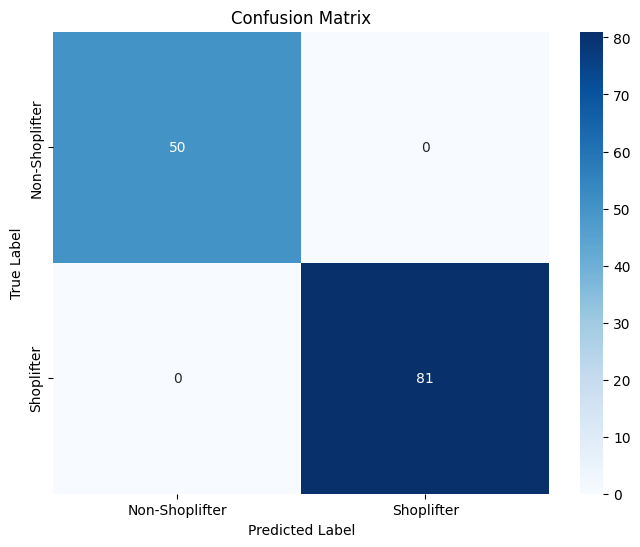

In [153]:


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


def print_evaluation_metrics(dataloader, model, device):
    y_pred, y_true = evaluate_model(dataloader, model, device)

    # Print classification report (precision, recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Shoplifter', 'Shoplifter']))

    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['Non-Shoplifter', 'Shoplifter'])

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_evaluation_metrics(test_loader, model, device)
